The University of Tokyo

Special Lectures in Information Science Ⅱ

Introduction to Near-Term Quantum Computing

# Variational quantum algorithms

Takashi Imamichi (May 24, 2024)

In [1]:
import qiskit

qiskit.__version__

'1.0.2'

## Computing an eigenvalue of a simple Hamiltonian

We compute an eigenvalue of Pauli Z matrix.

In [2]:
import numpy as np
from scipy.optimize import minimize

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler, Estimator

In [3]:
op = SparsePauliOp("Z")
op.to_matrix()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

In [4]:
result = np.linalg.eigh(op.to_matrix())
print("Eigenvalues:", result.eigenvalues)

Eigenvalues: [-1.  1.]


We try a circuit with a parameterized U gate as a variational form.

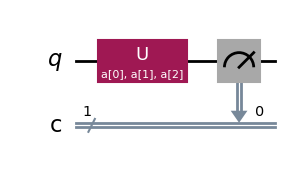

In [5]:
param = ParameterVector("a", 3)
qc = QuantumCircuit(1, 1)
qc.u(param[0], param[1], param[2], 0)
qc_estimator = qc.copy()
qc.measure(0, 0)
qc.draw("mpl")

In [6]:
sampler = Sampler()
estimator = Estimator()

We can compute probabilities of 0 and 1 with a random parameter values [1, 2, 3] using Sampler.

In [7]:
result = sampler.run(qc, [1, 2, 3]).result()
result

SamplerResult(quasi_dists=[{0: 0.77015115293407, 1: 0.22984884706593}], metadata=[{}])

We know that we can compute the expectation value of Z by $\langle Z \rangle = p_0 - p_1$ with a count probabilities $\{0: p_0, 1: p_1\}$. 

In [8]:
qd = result.quasi_dists[0]
qd.get(0, 0) - qd.get(1, 0)

0.5403023058681398

We can verify that the expectation value above is correct using Estimator.

In [9]:
result = estimator.run(qc_estimator, op, [1, 2, 3]).result()
result

EstimatorResult(values=array([0.54030231]), metadata=[{}])

We then make a function to receive parameter values of the variational form and return the expectation value $\langle Z \rangle$.

In [10]:
def cost(x):
    result = sampler.run(qc, x).result()
    qd = result.quasi_dists[0]
    expval = qd.get(0, 0) - qd.get(1, 0)
    # the following line shows the trajectory of the optimization
    print(qd, expval)
    return expval

Let's apply SciPy's `minimize` function to find the minimum eigenvalue of Z.

In [11]:
min_result = minimize(cost, [0, 0, 0], method="COBYLA", tol=1e-8)
min_result

{0: 1.0} 1.0
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.291926581726429, 1: 0.708073418273571} -0.4161468365471423
{0: 0.005003751699777, 1: 0.994996248300223} -0.9899924966004455
{0: 0.08341437040082, 1: 0.91658562959918} -0.8331712591983609
{0: 0.005003751699777, 1: 0.994996248300223} -0.9899924966004455
{0: 0.04423071229059, 1: 0.95576928770941} -0.9115385754188203
{0: 0.097263231384915, 1: 0.902736768615084} -0.8054735372301695
{0: 3.372408528e-06, 1: 0.999996627591472} -0.9999932551829449
{0: 0.002527164282365, 1: 0.997472835717635} -0.9949456714352694
{0: 0.000748950754013, 1: 0.999251049245987} -0.9985020984919737
{0: 3.372408528e-06, 1: 0.999996627591472} -0.9999932551829447
{0: 0.014908572508491, 1: 0.98509142749151} -0.9701828549830189
{0: 0.003877719224583, 1: 0.996122280775417} -0.9922445615508346
{0: 0.000853767915125, 1: 0.99

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0
       x: [ 3.142e+00  1.214e-01  1.242e-01]
    nfev: 81
   maxcv: 0.0

In [12]:
result = sampler.run(qc, min_result.x).result()
result

SamplerResult(quasi_dists=[{1: 1.0}], metadata=[{}])

## Exercise

Compute the eigenvalue of $Z \otimes Z$.

In [15]:
z2 = op.tensor(op)
print(z2)
print(z2.to_matrix())
result = np.linalg.eigh(z2.to_matrix())
print("Eigenvalues:", result.eigenvalues)

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
Eigenvalues: [-1. -1.  1.  1.]


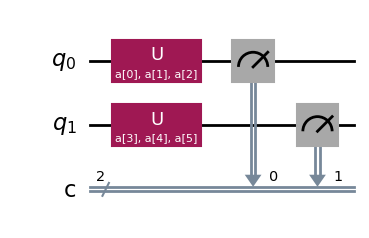

In [38]:
param = ParameterVector("a", 6)
qc = QuantumCircuit(2, 2)
qc.u(param[0], param[1], param[2], 0)
qc.u(param[3], param[4], param[5], 1)
qc_estimator = qc.copy()
qc.measure([0, 1], [0, 1])
qc.draw("mpl")

In [33]:
result = sampler.run(qc, [1, 2, 3, 4, 5, 6]).result()
result

SamplerResult(quasi_dists=[{0: 0.13337338235898, 1: 0.039804807209214, 2: 0.63677777057509, 3: 0.190044039856716}], metadata=[{}])

In [34]:
qd = result.quasi_dists[0]
qd.get(0, 0) - qd.get(1, 0) - qd.get(2, 0) + qd.get(3, 0)

-0.3531651555686095

In [35]:
result = estimator.run(qc_estimator, z2, [1, 2, 3, 4, 5, 6]).result()
result

EstimatorResult(values=array([-0.35316516]), metadata=[{}])

In [36]:
def cost(x):
    result = sampler.run(qc, x).result()
    qd = result.quasi_dists[0]
    expval = qd.get(0, 0) - qd.get(1, 0) - qd.get(2, 0) + qd.get(3, 0)
    print(qd, expval)
    return expval

In [39]:
min_result = minimize(cost, [0, 0, 0, 0, 0, 0], method="COBYLA", tol=1e-8)
min_result

{0: 1.0} 1.0
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.593132798365677, 1: 0.177018354568393, 2: 0.177018354568393, 3: 0.052830492497537} 0.2919265817264289
{0: 0.593132798365677, 1: 0.177018354568393, 2: 0.177018354568393, 3: 0.052830492497537} 0.29192658172642894
{0: 0.593132798365677, 1: 0.177018354568393, 2: 0.177018354568393, 3: 0.052830492497537} 0.2919265817264289
{0: 0.190553115473457, 1: 0.357095221094721, 2: 0.157394833510653, 3: 0.29495682992117} -0.028980109210747396
{0: 0.016633330903608, 1: 0.185784342816186, 2: 0.065539982315244, 3: 0.732042343964962} 0.49735134973714035
{0: 0.072402130935048, 1: 0.293743341512295, 2: 0.125339303503857, 3: 0.5085152240488} 0.1618347099676969
{0: 0.190553115473457, 1: 0.357095221094721, 2: 0.157394833510653, 3: 0.29495682992117} -0.028980109210747618
{0: 0.072402130935048, 1: 0.2937433415122

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9999999999999998
       x: [ 3.142e+00  3.086e-01 -1.633e-01 -1.369e-08 -2.451e-02
           -9.014e-01]
    nfev: 176
   maxcv: 0.0

In [40]:
result = sampler.run(qc, min_result.x).result()
result

SamplerResult(quasi_dists=[{1: 1.0}], metadata=[{}])

# Scaling Quantum Optimization with Qiskit Patterns

In this how-to we will learn about Qiskit Patterns and quantum approximate optimization. A Qiskit Pattern is an intuitive, repeatable set of steps for implementing a quantum computing workflow: 

<img src="imgs/patterns.png" alt="Drawing" style="float: left; width: 200px;"/>


            1. Map classical problem to abstract quantum circuits and operators
            2. Optimize problem for quantum execution
            3. Execute on a quantum computer
            4. Post-process, return result in classical format

We will apply the patterns to the context of **combinatorial optimization** and show how to solve the **Max-Cut** problem using the **Quantum Approximate Optimization Algorithm (QAOA)**, a hybrid (quantum-classical) iterative method. 

# Part 1: (Small-scale) Qiskit Pattern for Optimization

The first part of the session will use a small-scale Max-Cut problem to ilustrate the steps required to solve an optimization problem using a quantum computer.

Max-Cut is a hard to solve optimization problem with applications in clustering, network science, and statistical physics. The goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximum.

<img src="imgs/max-cut.png" alt="Max-Cut"/>

The workflow starts with a problem defined as a weighted graph:

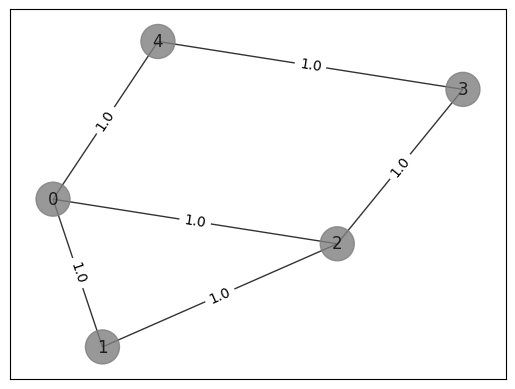

In [41]:
from demo_src.graph import generate_demo_graph, draw_graph

demo_graph = generate_demo_graph()
draw_graph(demo_graph)

Formally, this is an example of a classical combinatorial optimization problem with the form

\begin{align}
\min_{x\in \{0, 1\}^n}f(x)
\end{align}

Where the vector $x$ are the $n$ decision variables that correspond to every node of the graph. In this case, we have $n=5$, and each node can be 0 or 1 (included or not included in the cut). The minimum of $f(x)$ in this case will be when the number of edges traversed by the cut are maximal.

As you can see, there is nothing relating to quantum computing yet. We need to reformulate this problem into something that a quantum computer can understand.

## Step 1. Map the classical inputs to a quantum problem

The first step of the pattern is to map our classical problem (graph) into quantum **circuits** and **operators**.  To do this, we take advantage of a series of mathematical reformulations, such as the QUBO notation.


<div class="alert alert-block alert-info">
In the QAOA methodology, we ultimately want to have an operator (<b>Hamiltonian</b>) that will be used to represent the <b>cost function</b> of our hybrid algorithm, as well as a parametrized circuit (<b>Ansatz</b>) that we use to represent quantum states with candidate solutions to the problem. We can sample from these candidate states and then evaluate them using the cost function.
</div>

### Graph &rarr; QUBO

The first step of the mapping is a notation change, can express our problem in Quadratic Unconstrained Binary Optimization notation:

\begin{align}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align}

where $Q$ is a $n\times n$ matrix of real numbers, $n$ corresponds to number of nodes in our graph, and $x$ is the vector of binary variables introduced above.

In [42]:
from demo_src.map import map_graph_to_qubo

qubo = map_graph_to_qubo(demo_graph)
print(qubo.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 + 3*x_0
  + 2*x_1 + 3*x_2 + 2*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



### QUBO &rarr; Hamiltonian

We can reformulate the QUBO notation to express the problem as **a Hamiltonian, a function that represents the energy of a system**:

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

First, a variable change, we convert the binary variables $x_i$ to variables $z_i\in\{-1, 1\}$ by doing

\begin{align}
x_i = \frac{1-z_i}{2}.
\end{align}

Here, for example, we see that if $x_i$ is $0$ then $z_i$ is $1$. When we substitute the $x_i$'s for the $z_i$'s in the QUBO above, we obtain the equivalent formulations for our optimization task (the details of the computation are shown in Appendix A below):

\begin{align}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

Now, to obtain a quantum formulation of the problem, we promote the $z_i$ variables to a Pauli $Z$ matrix, i.e., a $2\times 2$ matrix of the form

\begin{align}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align}

When we substitute these matrices in the QUBO above we obtain the following Hamiltonian

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

<div class="alert alert-block alert-info">
We refer to this Hamiltonian as the <b>cost function Hamiltonian</b>. It has the property that its gound state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve our optimization problem we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.
</div>

In [43]:
from demo_src.map import map_qubo_to_ising

cost_hamiltonian, offset = map_qubo_to_ising(qubo)
print("Offset:", offset)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Offset: -3.0
Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### Hamiltonian &rarr; Quantum Circuit

The Hamiltonian $H_c$ contains the quantum definition of our problem. We will now create a quantum circuit that will help us *sample* good solutions form the quantum computer. The QAOA is inspired from quantum annealing and proceeds by applying alternating layers of operators in the quantum cirucit.

<div class="alert alert-block alert-info">
Losely speaking, the idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that we are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with the right angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. 
</div>
    
The quantum circuit that we generate is **parametrized** by $\gamma_i$ and $\beta_i$ , so we can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

<p align="center">
    <img src="imgs/circuit.png" alt="QAOA circuit"/>
</p>


In this case we will try an example with 1 QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.



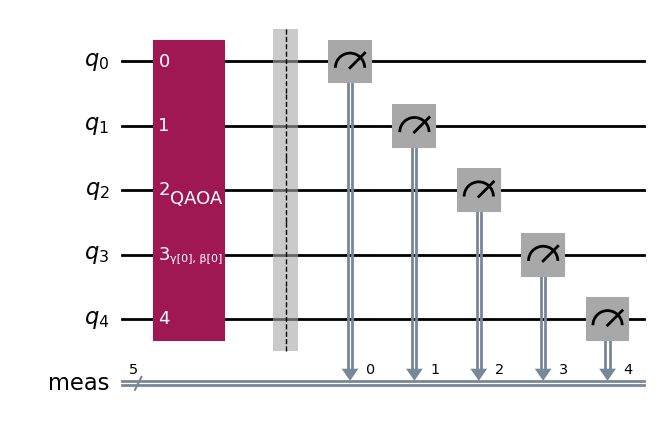

In [44]:
from demo_src.map import map_ising_to_circuit

circuit = map_ising_to_circuit(cost_hamiltonian, num_layers=1)
circuit.draw("mpl")

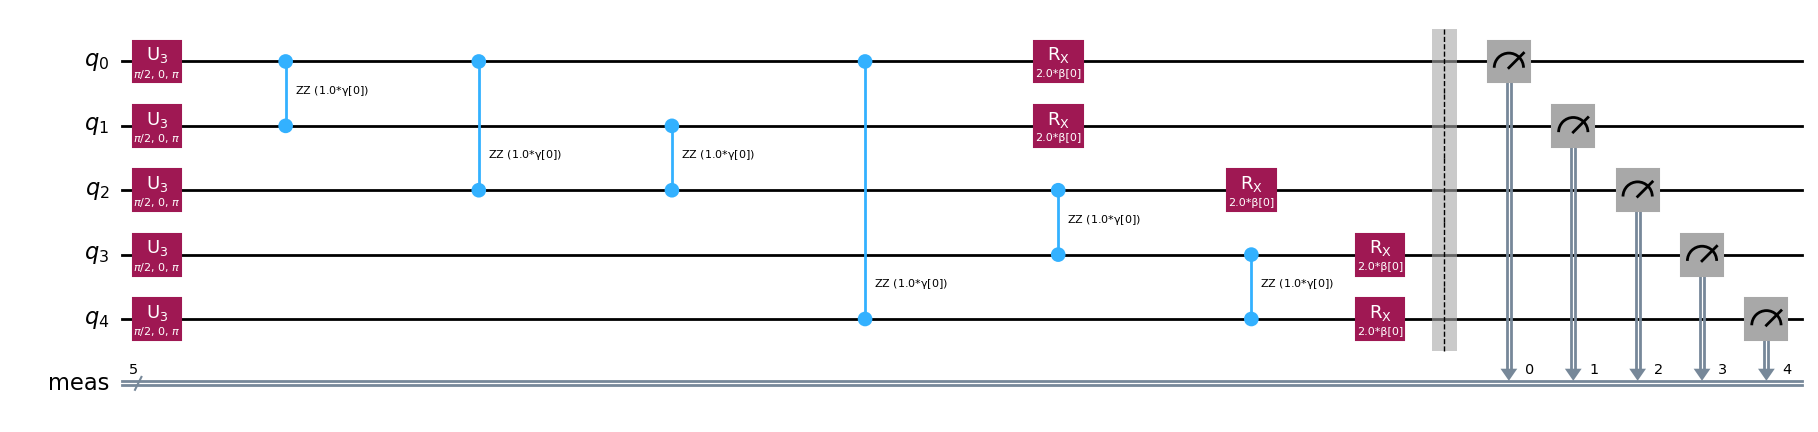

In [48]:
circuit.decompose(reps=3).draw("mpl", fold=-1)

In [45]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

## Step 2. Optimize problem for quantum execution

The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run in the hardware. To be able to run it in a quantum chip, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. We don't only want to get a circuit, but we want to make sure that the circuit is **optimized** for our purpose. 

Transpilation may involve many steps, such as:

<div class="alert alert-block alert-info">
    <ul>
      <li><b>Intial mapping</b> of the qubits in the circuit (i.e. decision variables) to physical qubits on the device.</li>
      <li><b>Unrolling</b> of the instructions in the quantum circuit to the hardware native instructions that the backend understands.</li>
      <li><b>Routing</b> of any qubits in the circuit that interact to physical qubits that are adjacent with one another.</li>
      <li><b>Error supression</b> by adding single-qubit gates to supress noise with dynamical decoupling.
    </ul> 

</div>

In this example, we have encapsulated a series of transpilation passes in the `optimize_circuit` function. The function takes a circuit and a backend (device) and returns an optimized circuit ready to run in the corresponding device:

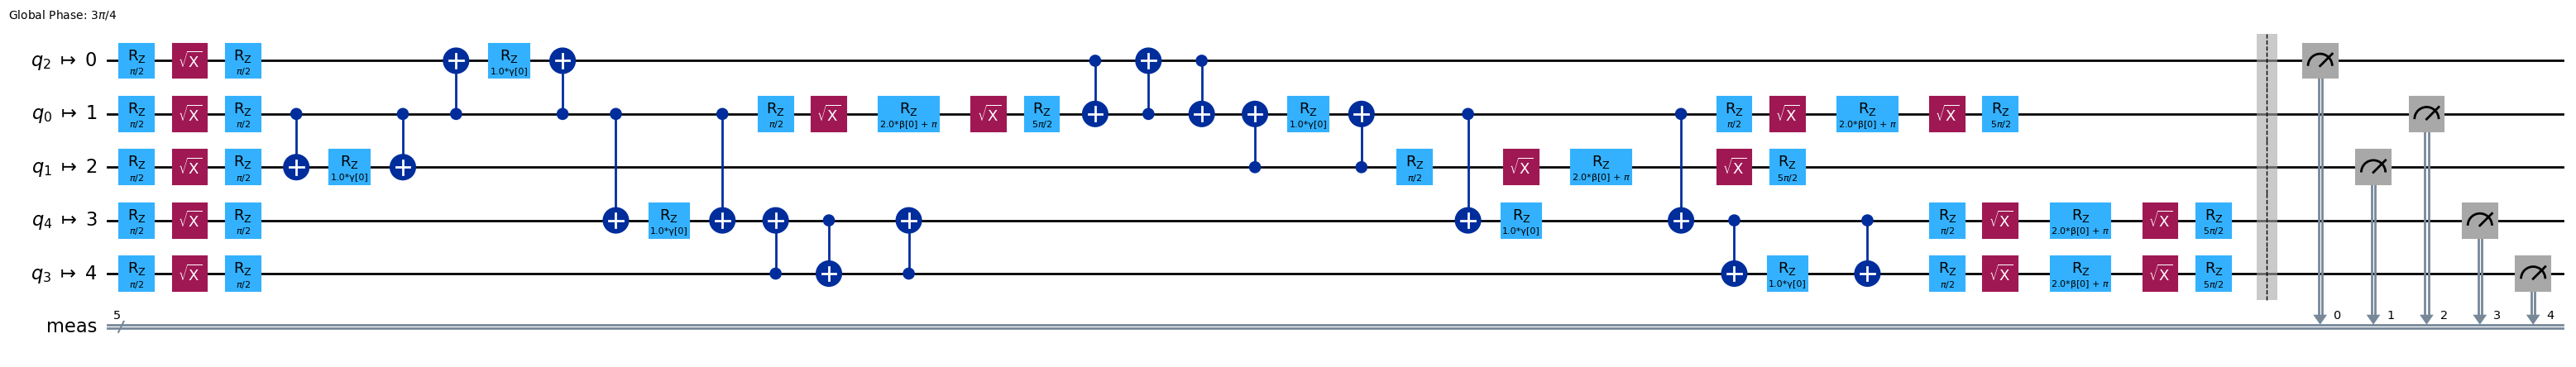

In [18]:
# IBM Quantum devices are named after cities
# For the purpose of the first part of this demo, we will
# use a simulated device from the "fake_provider"
from qiskit_ibm_runtime.fake_provider import FakeVigoV2

backend = FakeVigoV2()

from demo_src.transpile import optimize_circuit

opt_circuit = optimize_circuit(circuit, backend)
opt_circuit.draw("mpl", fold=False)

## Step 3. Execute using Qiskit Runtime primitives

In the general QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, where we run a series of circuit evaluations and use a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. In this demo, we will not optimize these parameters, we will simply assume that someone has done this for us. Note that finding such parameters is a research field in itself.

Once the optimal parameters are defined, we want to perform one final sampling with the resulting circuit to find our candidate solution.

<div class="alert alert-block alert-info">
This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state, for example <code>010101110000...</code> which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).
</div>
    
The execution is done through the **cloud** using the **Qiskit IBM Runtime service**.

### Define circuit with optimal parameters

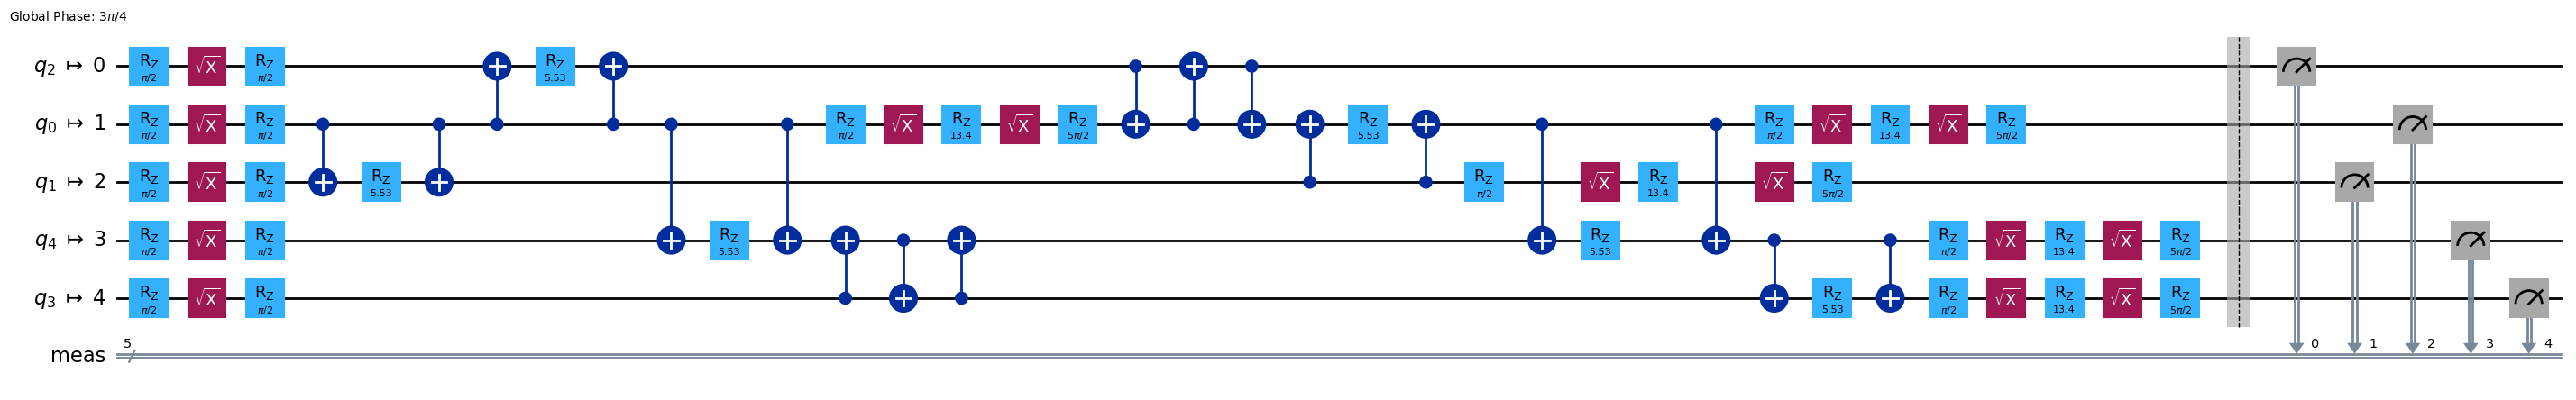

In [19]:
optimal_gamma = 5.11350346
optimal_beta = 5.52673212

candidate_circuit = opt_circuit.assign_parameters([optimal_gamma, optimal_beta])
candidate_circuit.draw("mpl", fold=False)

### Define backend and execution primitive

To interact with a IBM backends we use the **Qiskit Runtime Primitives**. There are two primitives: Sampler and Estimator, and the choice of primitive depends on the task that we want to run on the quantum computer. We are interested in drawing samples from the quantum computer, so we will use the **Sampler**. 

In [20]:
# For the purpose of the first part of this demo, we will
# use a simulated device from the "fake_provider"
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.primitives import BackendSampler

backend = FakeVigoV2()
sampler = BackendSampler(backend=backend)

### Run

The primitives offer a series of execution modes to schedule workloads on quantum devices, this example involves a single job, but a realistic QAOA workflow would be run iteratively in a Session.

<img src="imgs/exec-modes.png" alt="execution-modes" width="400"/>

In [21]:
final_distribution = sampler.run(candidate_circuit, shots=int(1e4)).result().quasi_dists[0]
print(final_distribution)

{24: 0.0074, 3: 0.0156, 0: 0.0092, 31: 0.007, 27: 0.0176, 18: 0.0438, 30: 0.0139, 21: 0.0463, 5: 0.0602, 2: 0.0118, 19: 0.0262, 14: 0.0275, 22: 0.0837, 9: 0.0844, 8: 0.0195, 17: 0.0302, 7: 0.0076, 20: 0.0855, 1: 0.0165, 26: 0.0553, 11: 0.088, 28: 0.0124, 10: 0.0478, 6: 0.0143, 29: 0.0092, 25: 0.0146, 16: 0.0166, 15: 0.0134, 23: 0.0172, 13: 0.0471, 4: 0.0207, 12: 0.0295}


## Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for our original problem, in this case, we are interested in the bitstring that will determine our optimal cut. The symmetries in the problem allow for 4 possible solutions. The sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that the four of the bitstrings are distictively more likely than the rest.

In [22]:
from demo_src.post import sample_most_likely

best_result = sample_most_likely(final_distribution, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [1 1 0 1 0]


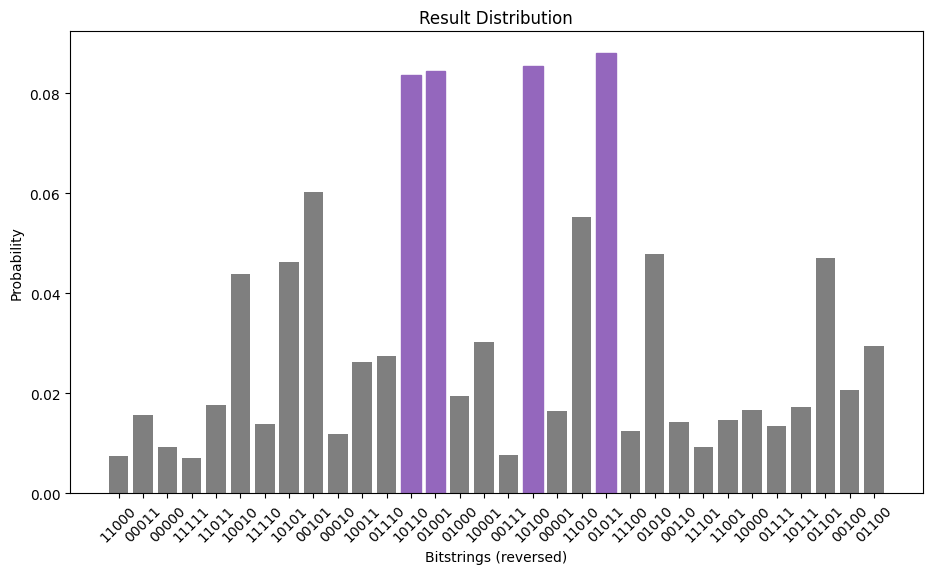

In [23]:
from demo_src.post import plot_distribution

plot_distribution(final_distribution)

### Visualize best cut

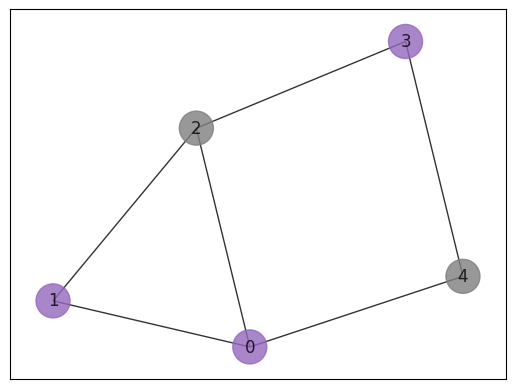

In [24]:
from demo_src.post import plot_result

plot_result(demo_graph, best_result)

# Appendix: Run Step 2-4 with a real device

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

In [26]:
service = QiskitRuntimeService()

In [ ]:
backend = service.least_busy(simulator=False, operational=True)
print(backend)

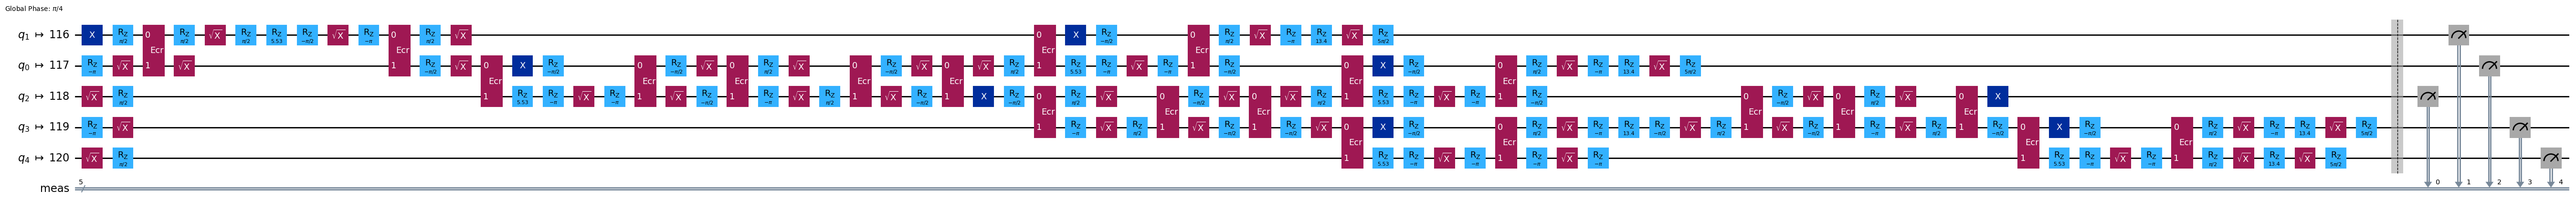

In [35]:
opt_circuit = optimize_circuit(circuit, backend)
candidate_circuit = opt_circuit.assign_parameters([optimal_gamma, optimal_beta])
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [36]:
sampler = Sampler(backend=backend)

/var/folders/lp/wqsk49dx0y595_730yr48twh0000gn/T/ipykernel_57696/180955793.py:1: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(backend=backend)


In [ ]:
job = sampler.run(candidate_circuit, shots=int(1e4))
job.job_id()

In [ ]:
job.status()

In [43]:
r_job = service.job(job.job_id())

In [44]:
final_distribution = r_job.result().quasi_dists[0]

print(final_distribution)

{0: 0.006388630136731, 1: 0.010694825334616, 2: 0.00742585143049, 3: 0.019835987635706, 4: 0.008510335517947, 5: 0.060591481148072, 6: 0.011469190567389, 7: 0.010659149041551, 8: 0.013798358587774, 9: 0.078866206982152, 10: 0.056232458079926, 11: 0.102150839880899, 12: 0.038177456737745, 13: 0.023486144745459, 14: 0.032000270208675, 15: 0.018153162354578, 16: 0.013566902528703, 17: 0.025202028344324, 18: 0.053418350505713, 19: 0.028490891329853, 20: 0.086164464049402, 21: 0.034612545990506, 22: 0.112920906344007, 23: 0.009924462409614, 24: 0.005544447219138, 25: 0.012210771802082, 26: 0.07130423291405, 27: 0.012821820731036, 28: 0.012651528512102, 29: 0.003832175772899, 30: 0.009846977706505, 31: 0.009047145450354}


In [45]:
best_result = sample_most_likely(final_distribution, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [0 1 1 0 1]


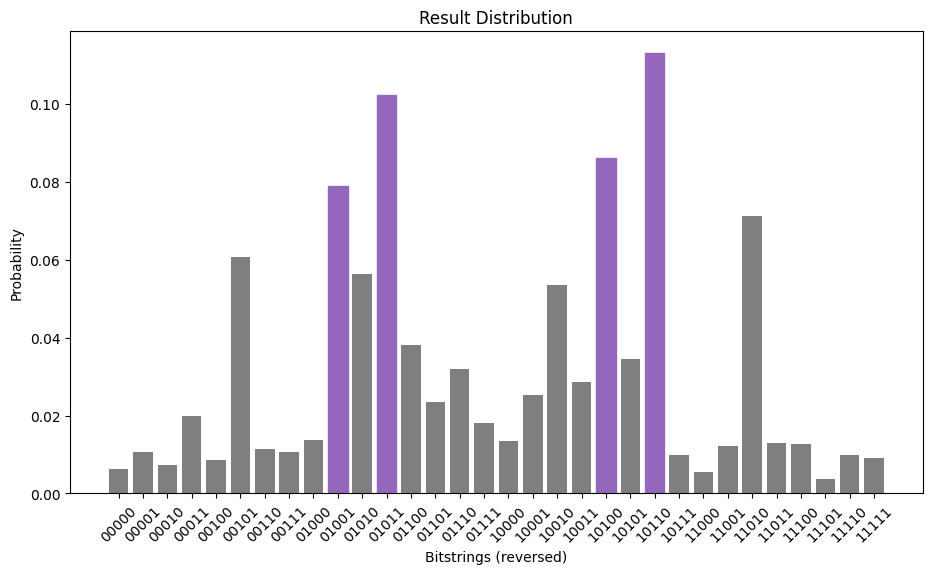

In [46]:
plot_distribution(final_distribution)

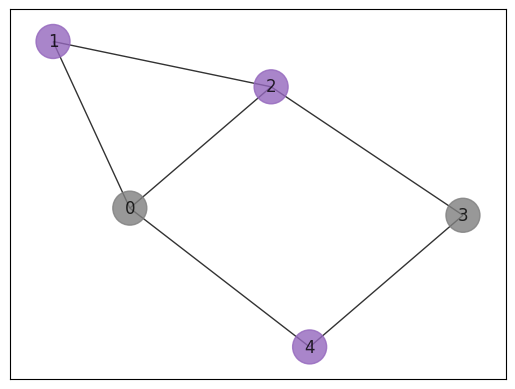

In [47]:
plot_result(demo_graph, best_result)